In [70]:
"""
Import necessary libraries
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv


In [2]:
"""
Read in the data
"""
opportunities = pd.read_excel('Opportunity_test_drop.xlsx')
NAICS = pd.read_excel('NAICS.xlsx')

/Users/benkarabinus/.local/share/virtualenvs/TOOL1_FINAL_PROJECT-_N6x3YZ3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


# Exploratory Data Analysis

## *Data Cleaning and Feature Engineering*

### Objectives
- Column naming convention
- NAICS categories must be joined with opportunities.
- Record creation date should be subtracted from system close date to create a new feature representing days an opportunity is active.
- The range of estimated revenue for opportunities varies greatly. A feature categorizing estimated revenue by quartile range should be added.
- Remove non-informative data.
- Handle missing data.
- Separate categorical and continuous features for further analysis.

In [3]:
"""dataframe summary"""
opportunities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 66 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   (Do Not Modify) Opportunity                                  3894 non-null   object        
 1   Entity ID (Account) (Account)                                3863 non-null   float64       
 2   Address 1: City (Account) (Account)                          3884 non-null   object        
 3   Address 1: State/Province (Account) (Account)                3880 non-null   object        
 4   Address 1: County (Account) (Account)                        3676 non-null   object        
 5   Address 1: Country/Region (Account) (Account)                3884 non-null   object        
 6   Address 1: ZIP/Postal Code (Account) (Account)               3881 non-null   object        
 7   Address 1: Lati

*Rename columns for ease of use and readability*

In [4]:
opportunities.columns = opportunities.columns.str.replace('\([^)]*\)', '', regex=True)
opportunities.columns = opportunities.columns.str.replace('\.', '', regex=True)
opportunities.columns = opportunities.columns.str.replace(':', '')
opportunities.columns = opportunities.columns.str.replace('/', '_')
opportunities = opportunities.rename(columns=lambda x : x.strip())
opportunities.columns = opportunities.columns.str.replace(' ','_')
opportunities.columns = opportunities.columns.str.replace('Address_1', '')
opportunities.columns = opportunities.columns.str.replace('^_', '', regex=True)
opportunities = opportunities.rename(columns=lambda x : x.strip())

In [5]:
"""rename system system generated GUID to opportunityID"""
opportunities.rename(columns={opportunities.columns[0]: 'opportunity_id', 'Status' : 'Won'},
                     inplace=True)
print(opportunities.columns[0])

opportunity_id


In [6]:
"""prepare NAICS codes for join"""
opportunities['NAICS'] = opportunities['NAICS'].str.replace(r'\D', '', regex=True)
opportunities['NAICS'] = opportunities['NAICS'].str.strip()
opportunities['NAICS'] = opportunities['NAICS'].fillna(value=0)
opportunities['NAICS'].isnull().sum()
opportunities['NAICS'] = opportunities['NAICS'].astype(int)

In [7]:
"""merge opportunities and NAICS"""
opportunities = pd.merge(opportunities, NAICS, how='inner', left_on = ['NAICS'],  right_on = ['mcg_naicscode'])

*Handle Missing and Non-informative Data*

- Drop columns containing non-informative data
- Replace missing values for categorical features with "\_missing_"
- Replace missing numerical features with appropriate values or drop if necessary

In [8]:
"""drop unecessary columns"""
"""
opportunities.drop(columns=['Row_Checksum', 'LOB_Service_Line', 'Solution_Set', 'D&B_Company', 
                            'D&B_Financial', 'IPM_Date_Acquired', 'IPM_Date_Lost', 'Import_Date', 
                            'Record_Created_On', 'Modified_On', 'Actual_Close_Date', 'Sales_Stage', 
                            'Original_Opportunity', 'D&B_Company', 'Assets','Est_Fees', 'Total_Amount',
                            'Revenue_This_Year_Aggregated', 'Status_Reason', 'MSA', 'Rating','Consulting_Lead',
                            'Region', 'Deliverability_Rating', 'Relationship_Strength', 'mcg_naicscode',
                            'mcg_name', 'mcg_sicdescription', 'Commissonable', 'CJP_Target', 'Account_Original_Source', 
                            'Business_Type','D&B_NAICS', 'National_Initiative', 'Territory_Code', 'Last_Interaction',
                            'NAICS', 'Created_By', 'mcg_description', 'mcg_subsectortext0', 'Collaboration-Approved_Date', 'Description'], axis=1, inplace=True)

print("Dropping non-informative features reduces the dimension of the dataset to {} features.".format(len(opportunities.columns)))
"""

'\nopportunities.drop(columns=[\'Row_Checksum\', \'LOB_Service_Line\', \'Solution_Set\', \'D&B_Company\', \n                            \'D&B_Financial\', \'IPM_Date_Acquired\', \'IPM_Date_Lost\', \'Import_Date\', \n                            \'Record_Created_On\', \'Modified_On\', \'Actual_Close_Date\', \'Sales_Stage\', \n                            \'Original_Opportunity\', \'D&B_Company\', \'Assets\',\'Est_Fees\', \'Total_Amount\',\n                            \'Revenue_This_Year_Aggregated\', \'Status_Reason\', \'MSA\', \'Rating\',\'Consulting_Lead\',\n                            \'Region\', \'Deliverability_Rating\', \'Relationship_Strength\', \'mcg_naicscode\',\n                            \'mcg_name\', \'mcg_sicdescription\', \'Commissonable\', \'CJP_Target\', \'Account_Original_Source\', \n                            \'Business_Type\',\'D&B_NAICS\', \'National_Initiative\', \'Territory_Code\', \'Last_Interaction\',\n                            \'NAICS\', \'Created_By\', \'mcg_

In [9]:
opportunities.drop(columns=['mcg_naicscode','mcg_name', 'mcg_sicdescription',
                            'NAICS', 'mcg_description', 'mcg_subsectortext0'], 
                            axis=1, inplace=True)

In [10]:
for i in range(len(opportunities.columns)):
    print(i, opportunities.columns[i])

0 opportunity_id
1 Entity_ID
2 City
3 State_Province
4 County
5 Country_Region
6 ZIP_Postal_Code
7 Latitude
8 Longitude
9 Currency
10 Est_Revenue
11 Lead_Source
12 Type
13 Probability
14 Account_Rating
15 No_of_Employees
16 Open_Deals
17 Open_Revenue
18 Customer_Need
19 Engagement_Type
20 Owner
21 Account_Mgmt_1
22 Account_Mgmt_2
23 Relationship_Lead
24 Annual_Revenue
25 Business_Developer_1
26 Business_Developer_2
27 Created_On
28 Est_Close_Date
29 System_Close_Date
30 Won
31 Referral_Contact
32 Approval_Status
33 PSE_1
34 PSE_2
35 CFY_RSM_Services_Spend
36 Current_Situation
37 EAL
38 Internationally_Active
39 IPM_Lost_Reason
40 Microsoft_Enterprise_Agreement
41 Microsoft_Reference_Program
42 Other_Software
43 Preferred_Method_of_Contact
44 Preferred_Service
45 Private_Equity
46 Referral_Notes
47 Referring_Firm
48 Revenue_Last_Year
49 Revenue_This_Year
50 Territory
51 VIP_Client?
52 Full_Name
53 Full_or_Part-time
54 Function
55 Job_Title
56 Office_Location
57 Category
58 Client_Status

In [11]:
"""rename NAICS columns"""
opportunities.rename(columns={'mcg_industry_displayname' : 'industry','mcg_industrysector_displayname' : 'industry_sector'}, inplace=True)

In [12]:
"""verify data type for datetime columns"""
print(opportunities['Created_On'].dtype)
print(opportunities['Est_Close_Date'].dtype)
print(opportunities['System_Close_Date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


In [13]:
"""create new feature days active"""
opportunities['days_active'] = opportunities['System_Close_Date'] - opportunities['Created_On']
opportunities['days_active'] = opportunities['days_active'] / np.timedelta64(1, 'D')
opportunities['days_active'][opportunities['days_active'] <= 0].count()

858

Creating the new feature "days_active" shows the existence of 858 opportunities that were active for a negative amount of days. This is due to errors with data entry. For the purpose of this analysis all sales opportunities with negative days active will be removed from the data.

In [14]:
"""drop problem dates"""
problem_dates = \
opportunities[['days_active', 'Created_On', 'System_Close_Date']][opportunities['days_active'] < 10].index
opportunities.drop(index=problem_dates, inplace=True)

In [15]:
"""create a new feature "revenue_size" as categorical representation of estimated revenue for a given opportunity"""
pd.set_option('display.float_format', lambda x : '%.2f' % x)
revenue_range = opportunities['Est_Revenue'].describe()
opportunities.loc[opportunities['Est_Revenue'].between(revenue_range['min'], revenue_range['25%'], 'both'), 'revenue_size'] = 'low'
opportunities.loc[opportunities['Est_Revenue'].between(revenue_range['25%'], revenue_range['75%'], 'right'), 'revenue_size'] = 'med'
opportunities.loc[opportunities['Est_Revenue'].between(revenue_range['75%'], revenue_range['max'], 'right'), 'revenue_size'] = 'high'

In [16]:
"""ensure no missing values in key columns"""
opportunities[['opportunity_id', 'Entity_ID']].isna().sum()

opportunity_id    0
Entity_ID         0
dtype: int64

Separate continuous and categorical features

In [17]:
"""seperate numerical and categorical columns"""
opportunityID = opportunities[['opportunity_id', 'Entity_ID']].copy()
opp_numeric = opportunities.select_dtypes(include=[np.number])
opp_non_numeric = opportunities.select_dtypes(exclude=[np.number])
opp_non_numeric.drop(columns=['City', 'State_Province', 'Country_Region','County',
                             'ZIP_Postal_Code'], inplace=True)
opp_geographic = opportunities.iloc[:, 0:9].copy()

In [18]:
opp_numeric = pd.merge(opportunityID, opp_numeric, left_index=True, right_index=True, how='inner')
opp_non_numeric = pd.merge(opportunityID, opp_non_numeric, left_index=True, right_index=True, how='inner')
opp_numeric.drop(columns=['Entity_ID_y', 'Latitude', 'Longitude'], axis=1, inplace=True)
opp_non_numeric.drop(columns=['opportunity_id_y'], axis=1, inplace=True)
opp_numeric.rename(columns={'Entity_ID_x' : 'Entity_ID'}, inplace=True)
opp_non_numeric.rename(columns={'opportunity_id_x' : 'opportunity_id'}, inplace=True)
opp_numeric.set_index(['opportunity_id', 'Entity_ID'], inplace=True)
opp_non_numeric.set_index(['opportunity_id', 'Entity_ID'], inplace=True)
opp_geographic.set_index(['opportunity_id', 'Entity_ID'], inplace=True)

In [19]:
"""sanity check"""
print(opp_numeric.shape)
print(opp_non_numeric.shape)

(1864, 20)
(1864, 40)


In [20]:
opp_non_numeric.isnull().sum()

Currency                             0
Lead_Source                          0
Type                                 0
Probability                        144
Account_Rating                     851
Customer_Need                     1647
Engagement_Type                   1665
Owner                                0
Account_Mgmt_1                     818
Account_Mgmt_2                    1855
Relationship_Lead                    0
Business_Developer_1              1354
Business_Developer_2              1799
Created_On                           0
Est_Close_Date                       0
System_Close_Date                    0
Won                                  0
Referral_Contact                  1857
PSE_1                             1634
PSE_2                             1790
EAL                               1652
Internationally_Active             733
IPM_Lost_Reason                   1596
Microsoft_Enterprise_Agreement     760
Microsoft_Reference_Program       1447
Other_Software           

In [21]:
"""fillna for categorical features with value "_missing_" """
opp_non_numeric.fillna(value='_missing_', inplace=True)
opp_non_numeric.isnull().sum()

Currency                          0
Lead_Source                       0
Type                              0
Probability                       0
Account_Rating                    0
Customer_Need                     0
Engagement_Type                   0
Owner                             0
Account_Mgmt_1                    0
Account_Mgmt_2                    0
Relationship_Lead                 0
Business_Developer_1              0
Business_Developer_2              0
Created_On                        0
Est_Close_Date                    0
System_Close_Date                 0
Won                               0
Referral_Contact                  0
PSE_1                             0
PSE_2                             0
EAL                               0
Internationally_Active            0
IPM_Lost_Reason                   0
Microsoft_Enterprise_Agreement    0
Microsoft_Reference_Program       0
Other_Software                    0
Preferred_Method_of_Contact       0
Private_Equity              

In [22]:
opp_numeric.isnull().sum()

Est_Revenue                  0
No_of_Employees              8
Open_Deals                   0
Open_Revenue                 0
Annual_Revenue               9
Approval_Status           1864
CFY_RSM_Services_Spend     277
Current_Situation         1864
Preferred_Service         1864
Referring_Firm            1864
Revenue_Last_Year         1864
Revenue_This_Year         1864
Territory                 1864
Category                  1864
D&B_Financial             1864
D&B_Ultimate_Parent       1864
Market_Capitalization     1864
Market_Capitalization     1864
PFY_RSM_Services_Spend     277
days_active                  0
dtype: int64

In [23]:
perc = 0.50
threshold = int(perc*opportunities.shape[0])
opp_numeric.dropna(axis=1, thresh=threshold, inplace=True)
print("Dropping features missing 50 percent or more data reduces the dimension of the dataset"
" to {} features.".format(len(opp_numeric.columns)))

Dropping features missing 50 percent or more data reduces the dimension of the dataset to 8 features.


Printing a count of null values for each continuous variable shows that the columns "CFY_RSM_Services_Spend" and "PFY_RSM_Services_Spend" are both missing 277 observations each. It's assumed that missing values in these columns represent clients who have not purchased consulting services from the firm in either of the two periods. As such, missing values will be replaced with 0.

In [24]:
"""fill current fiscal year spend and previous fiscal year spend with 0, assuming if value not given no prior or current spend"""
opp_numeric['CFY_RSM_Services_Spend'] = opp_numeric['CFY_RSM_Services_Spend'].fillna(value=0)
opp_numeric['PFY_RSM_Services_Spend'] = opp_numeric['PFY_RSM_Services_Spend'].fillna(value=0)

In [25]:
"""Drop rows where annual revenue or number of employees is missing
opp_numeric = opp_numeric.dropna(subset=['Annual_Revenue', 'No_of_Employees'])
"""

"Drop rows where annual revenue or number of employees is missing\nopp_numeric = opp_numeric.dropna(subset=['Annual_Revenue', 'No_of_Employees'])\n"

In [26]:
"""print dimensions"""
opp_numeric.shape

(1864, 8)

In [27]:
"""sanity check"""
opp_numeric.isnull().sum()

Est_Revenue               0
No_of_Employees           8
Open_Deals                0
Open_Revenue              0
Annual_Revenue            9
CFY_RSM_Services_Spend    0
PFY_RSM_Services_Spend    0
days_active               0
dtype: int64

## *Explore Categorical Features*

Objectives
- Examine frequency distruibution of categorical features
- Drop further features based on domain knowledge

In [28]:
"""Transform "Status" to binary outcome"""
opp_non_numeric['Won'] = opp_non_numeric['Won'].apply(lambda x : 1 if (x == 'Won') else 0)

In [29]:
"""Print win/loss percentage"""
opp_non_numeric.value_counts('Won',normalize=True)

Won
0   0.52
1   0.48
dtype: float64

In [30]:
"""Win vs Loss by estimated revenue and industry"""
wid = pd.DataFrame(opp_non_numeric[['Won', 'revenue_size', 'industry']].groupby(['revenue_size', 'industry']).value_counts('Won', normalize=True))
wid.reset_index(inplace=True)

In [31]:
opp_non_numeric.value_counts('Type', normalize=True)

Type
Existing Relationship - New Business   0.45
Existing Relationship - Renewal        0.28
New Relationship - New Business        0.27
dtype: float64

In [32]:
fig = px.histogram(opp_non_numeric, x='Won', color='Type', barmode='group')
fig.update_layout(title_text='Won/Lost Opportunities by Type', title_x=0.5)

In [33]:
opp_non_numeric.value_counts('Client_Status', normalize=True)

Client_Status
Existing Client   0.69
_missing_         0.17
New               0.15
dtype: float64

The features "Type" and "Client_Status" provide similar infomation abut a given opportunity. Type is a more informative and more complete feature. Client_Status will be dropped.

In [34]:
opp_non_numeric.drop(columns=['Client_Status'], inplace=True)

In [35]:
opp_non_numeric.value_counts('Currency')

Currency
US Dollar    1864
dtype: int64

"Currency" takes on a singe value "US Dollar." The feature adds no valuable information about the data.

In [36]:
opp_non_numeric.drop(columns=['Currency'], inplace=True)

In [37]:
opp_non_numeric.value_counts('Lead_Source')

Lead_Source
Inactive - Junction Solutions         393
BD Activity                           301
Partner                               269
Director                              197
Referral - Other                      190
Inside Sales                          112
Manager                               103
Referral - Microsoft                   78
Marketing Campaign - National          62
Website                                51
Other                                  29
National Call Center                   27
RSM System Selection                   27
Reputation                              9
COI                                     4
RFP                                     4
Marketing Campaign - Regional           3
RSM Alumni                              2
RSM Int'l Inbound                       1
Inactive - Explore Consulting, LLC      1
Trade Show                              1
dtype: int64

In [38]:
opp_non_numeric.value_counts('Preferred_Method_of_Contact')

Preferred_Method_of_Contact
Any    1864
dtype: int64

"Preferred_Method_of_Contact" takes on a single value any. The feature provides no additional information about the dataset.

In [39]:
opp_non_numeric.drop(columns=['Preferred_Method_of_Contact'], inplace=True)

In [40]:
opp_non_numeric.value_counts("VIP_Client?")

VIP_Client?
No    1864
dtype: int64

"VIP_Client?" takes on a single value "No." The feature provides no additional information about the dataset

In [41]:
opp_non_numeric.drop(columns=['VIP_Client?'], inplace=True)

In [42]:
fig = px.treemap(opp_non_numeric, path=[px.Constant('all'), 'industry', 'industry_sector'], 
                 values = 'Won', title='Wins by Industry Sector')
fig.update_layout(title_x=0.5, margin = dict(t=35, l=25, r=25, b=25))
fig.show()

### Methods

- Print Summary Statistics
- Inspect Data Distribution

In [43]:
"""Print summary statistics"""
pd.set_option('display.float_format', lambda x : '%.2f' % x)
opp_numeric.describe()

,Est_Revenue,No_of_Employees,Open_Deals,Open_Revenue,Annual_Revenue,CFY_RSM_Services_Spend,PFY_RSM_Services_Spend,days_active
count,1864.00,1856.00,1864.00,1864.00,1855.00,1864.00,1864.00,1864.00
mean,597278.87,1573.03,0.90,355214.65,412761653.60,481431.32,470588.04,165.83
std,1095086.35,4936.64,2.21,1069502.42,1226698144.34,1186845.76,1032951.63,204.24
min,-1.00,0.00,0.00,0.00,0.00,-21385.15,-52946.11,10.02
25%,31611.25,75.00,0.00,0.00,17314300.50,0.00,0.00,34.40
50%,140000.00,350.00,0.00,0.00,104158463.00,25394.46,31335.26,90.06
75%,700000.00,1020.00,1.00,50000.00,426034499.50,311407.75,391719.66,209.39
max,14047440.00,95000.00,34.00,7000000.00,30000000000.00,7308498.75,6214816.48,1554.61


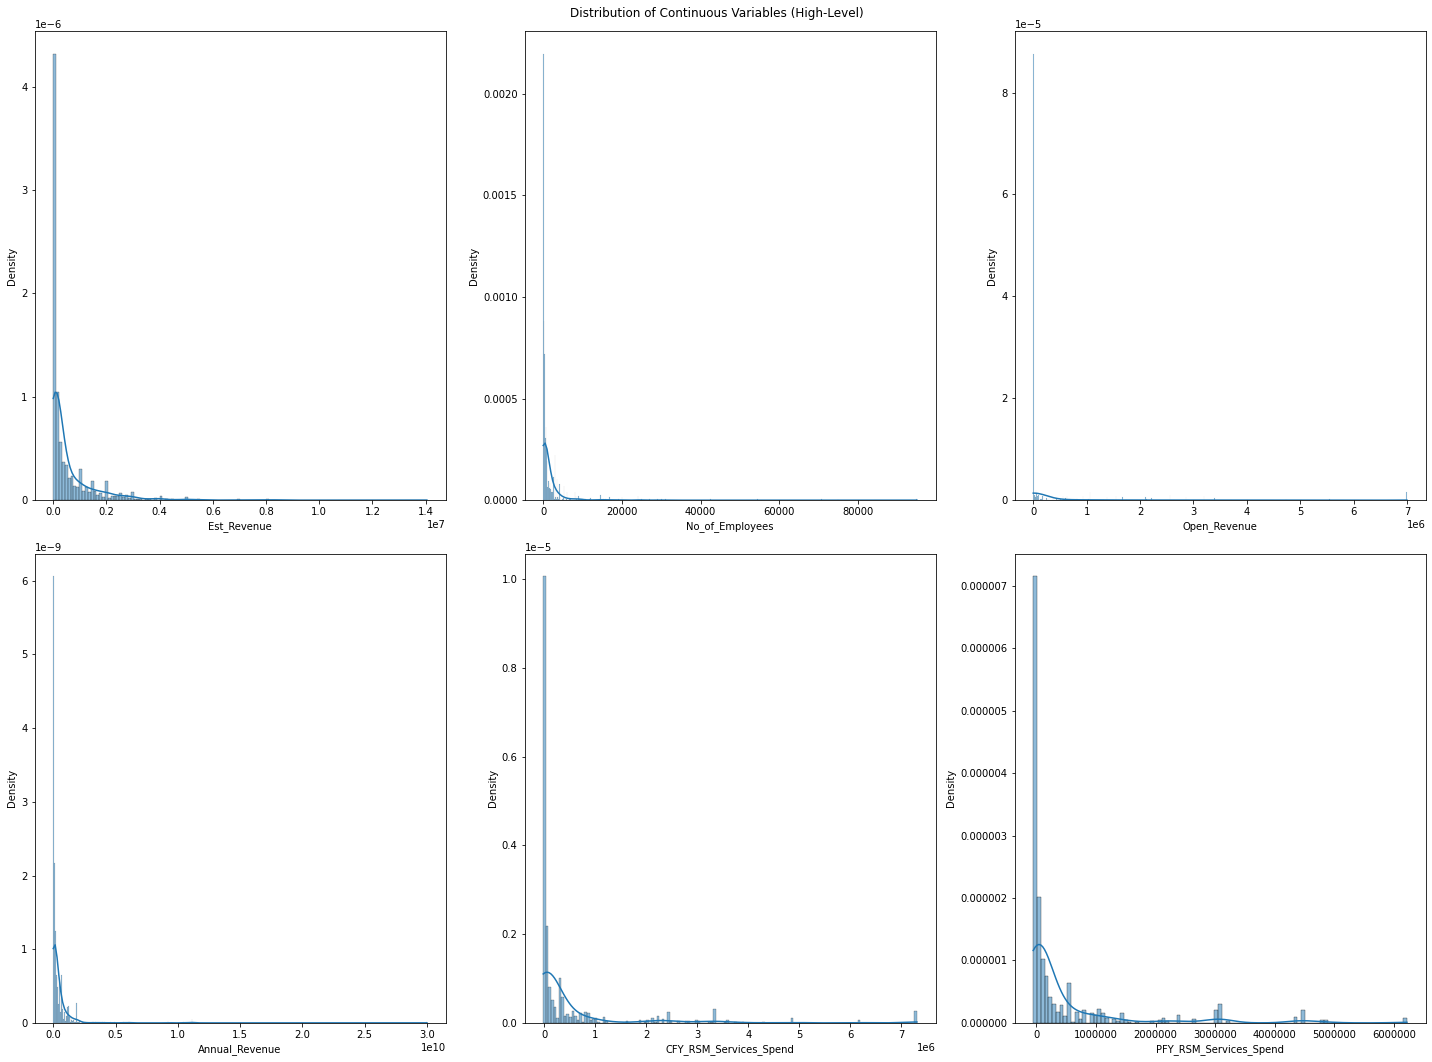

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
sns.histplot(opp_numeric, x='Est_Revenue', stat='density', kde=True, ax=ax[0,0])
sns.histplot(opp_numeric, x='No_of_Employees', stat='density', kde=True, ax=ax[0, 1])
sns.histplot(opp_numeric, x='Open_Revenue', stat='density', kde=True, ax=ax[0, 2])
sns.histplot(opp_numeric, x='Annual_Revenue', stat='density', kde=True, ax=ax[1,0])
sns.histplot(opp_numeric, x='CFY_RSM_Services_Spend', stat='density', kde=True, ax=ax[1, 1])
sns.histplot(opp_numeric, x='PFY_RSM_Services_Spend', stat='density', kde=True, ax=ax[1, 2])
plt.ticklabel_format(style='Plain')
fig.suptitle('Distribution of Continuous Variables (High-Level)')
plt.tight_layout()

## *Explore Relationship Between Variables*

### Methods

- Pearson's Correlation
- Distribution Plots

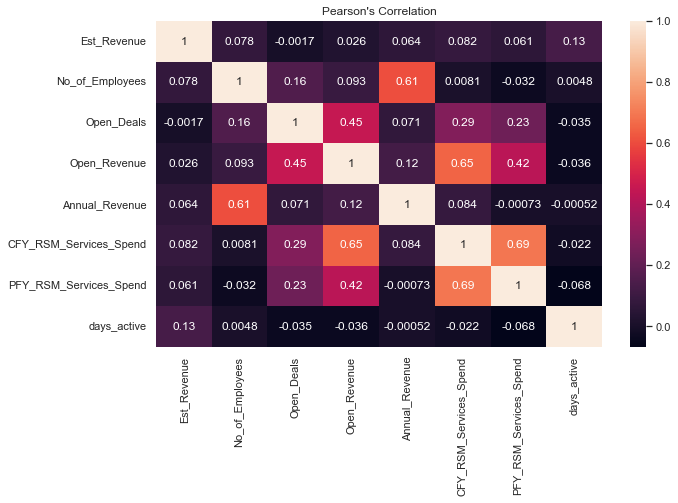

In [45]:
# plot correlation of numeric data
sns.set(rc={"figure.figsize":(10, 6)})
opp_numeric_corr = opp_numeric.fillna(value=0)
correlation = sns.heatmap(opp_numeric_corr.corr(), cmap='rocket',
                          annot=True).set_title('Pearson\'s Correlation')

In [46]:
"""recombine data"""
opportunities = pd.merge(opp_numeric, opp_non_numeric, left_index=True, right_index=True, how='inner')
opportunities = pd.merge(opportunities, opp_geographic, left_index=True, right_index=True, how='inner')
cols = opportunities.columns.values.tolist()
cols.insert(len(cols), cols.pop(cols.index('Won')))
opportunities = opportunities[cols]
#for i in range(len(opportunities.columns)):
 #   print(i, opportunities.columns[i])

In [47]:
opp_non_numeric.shape

(1864, 36)

In [48]:
opportunities.isnull().sum()

Est_Revenue                        0
No_of_Employees                    8
Open_Deals                         0
Open_Revenue                       0
Annual_Revenue                     9
CFY_RSM_Services_Spend             0
PFY_RSM_Services_Spend             0
days_active                        0
Lead_Source                        0
Type                               0
Probability                        0
Account_Rating                     0
Customer_Need                      0
Engagement_Type                    0
Owner                              0
Account_Mgmt_1                     0
Account_Mgmt_2                     0
Relationship_Lead                  0
Business_Developer_1               0
Business_Developer_2               0
Created_On                         0
Est_Close_Date                     0
System_Close_Date                  0
Referral_Contact                   0
PSE_1                              0
PSE_2                              0
EAL                                0
I

## *_Feature Selection_*

- Mutual Information Criteria

In [49]:
"""preprocessing"""

# drop columns that will not be included in final model
opportunities.drop(columns=['Est_Close_Date', 'System_Close_Date', 'Created_On','Latitude', 
                            'Longitude', 'City', 'County', 'ZIP_Postal_Code' ], inplace=True)
opportunities.fillna(value=0, inplace=True)
# susbset features for mutual infomation feature selection
x = opportunities.iloc[:, :-1]
y = opportunities.iloc[:, -1]
# index continuous and categorical features
numeric_idx = x.select_dtypes(include=['int64', 'float64']).columns
categorical_idx = x.select_dtypes(include=['object', 'bool']).columns
# encode categorical featurs as integers
oe = OrdinalEncoder()
oe.fit(x[categorical_idx])
#x = pd.get_dummies(x, drop_first=True)
# apply robust scaling to continuous features
x[categorical_idx] = oe.transform(x[categorical_idx])
numeric_scaler = RobustScaler()
x[numeric_idx] = numeric_scaler.fit_transform(x[numeric_idx])
#le = LabelEncoder()
#le.fit(y)
#y = le.transform(y)


In [50]:
"""define Mutual Info classifier"""

# get numeric indices for categorical features
discrete_idx =[]
for col in categorical_idx:
   discrete_idx.append(x.columns.get_loc(col))
# fit mutual_info_class passing the indices of discrete columns as param
importance = mutual_info_classif(x, y, random_state=14, discrete_features=discrete_idx)
importance = pd.Series(importance, index=x.columns)
importance.sort_values(ascending=False, inplace=True)

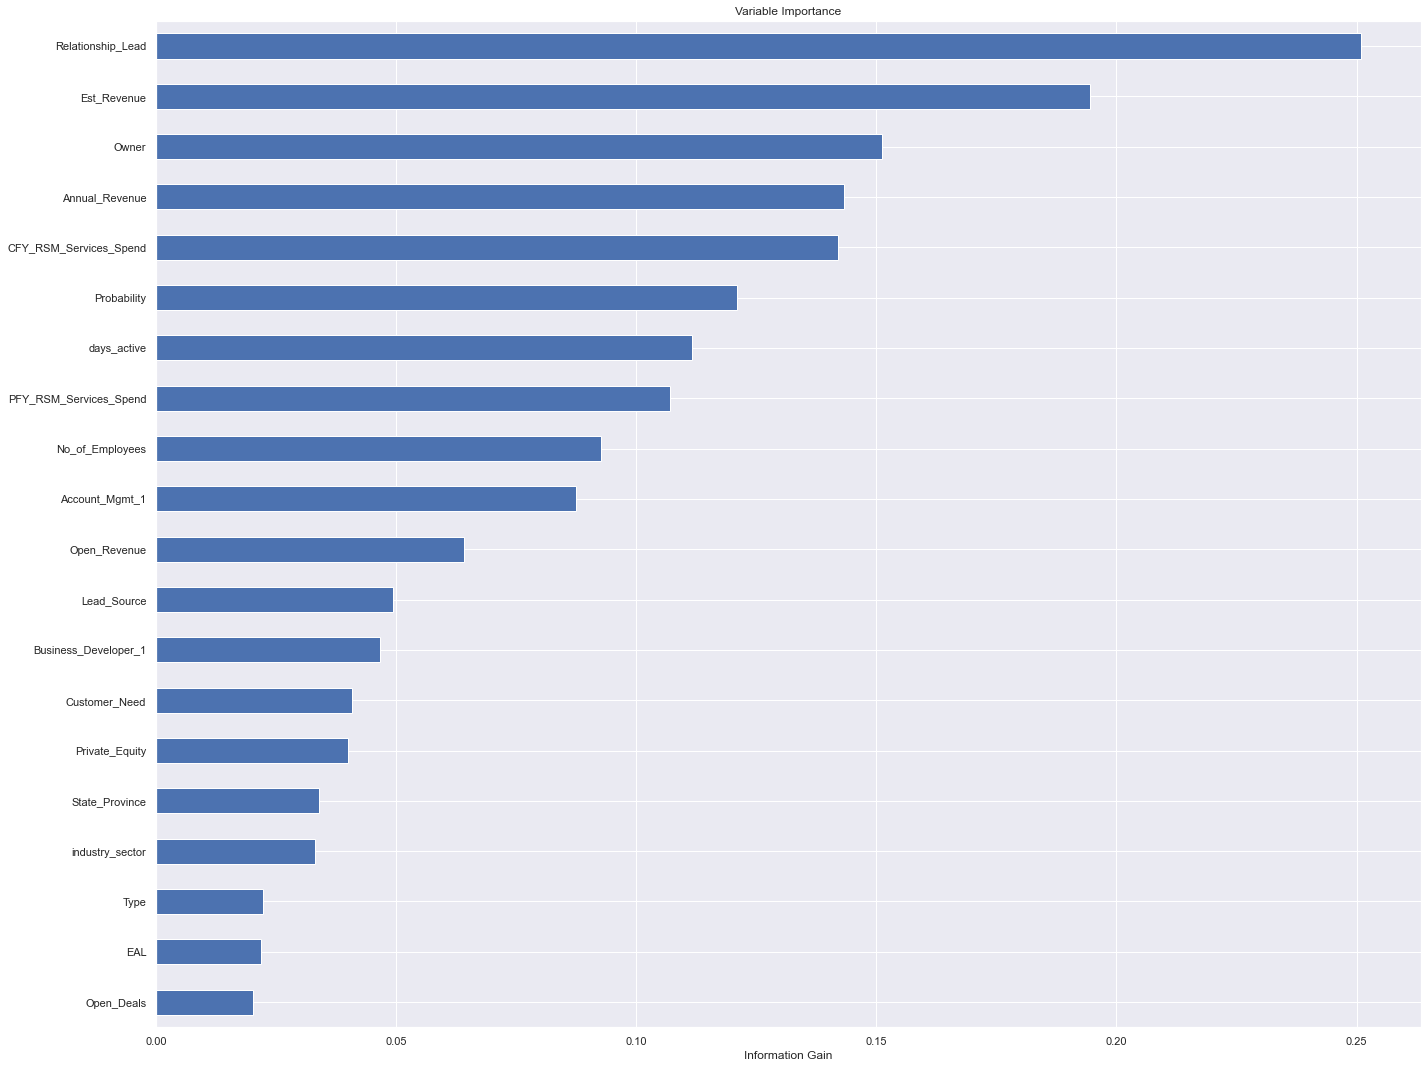

In [51]:
"""Plot variable importance"""
importance[0:20].sort_values(ascending=True).plot.barh(figsize=(20, 15))
plt.title('Variable Importance')
plt.xlabel('Information Gain')
plt.tight_layout()

In [52]:
"""select top 20 features """
x = x[importance[0:20].index]
x = x[importance[0:20].index]

## *_Model Selection_*

- Light Gradient Boosted Machine (lgbm)
- Extreme Gradient Boosting (xgboost)

In [59]:
"""preprocessing"""
# subset top 20 features for lgbm and xgboost
x = opportunities[importance[0:20].index].copy()
y = opportunities.iloc[:, -1].copy()
# create index of continuous and categorical features
numeric_idx = x.select_dtypes(include=['int64', 'float64']).columns
categorical_idx = x.select_dtypes(include=['object', 'bool']).columns
# apply one hot encoding and robust scaler to the lgm and xgboost data
x[categorical_idx] = x[categorical_idx].astype('category')
x = pd.get_dummies(x, drop_first=True)
numeric_scaler = RobustScaler()
x[numeric_idx] = numeric_scaler.fit_transform(x[numeric_idx])
# lightgbm does not support existence of JSON special characters in feature names
x = x.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# subset top 20 features for catboost
x_catboost = opportunities[importance[0:20].index].copy()
y_catboost = opportunities.iloc[:, -1].copy()
x_catboost[categorical_idx] = x_catboost[categorical_idx].astype('category')
x_catboost_categorical_idx = categorical_idx.values
x_catboost[numeric_idx] = numeric_scaler.fit_transform(x_catboost[numeric_idx])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(x_catboost, y,
                                                                    test_size=0.30,
                                                                    random_state=1)

In [73]:
"""utility function to print classification_report for models"""
def print_report(y_test, predictions):
    target_names = ['Lost', 'Won']
    print(classification_report(y_test, predictions, target_names=target_names))

In [79]:
"""utility function to plot feature importance for models"""

def plot_importance(feature_names, feature_importance, model_type, importance_metric):

    #Create a DataFrame of results
    model_results = {'feature_names':feature_names,'feature_importance':feature_importance}
    model_results = pd.DataFrame(catboost_results)
    # sort results by decreasing feature importance
    model_results.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    # specify plot size
    plt.figure(figsize=(15,8))
    # create the plot
    sns.barplot(x=catboost_results['feature_importance'], y=catboost_results['feature_names'])
    # add labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel(importance_metric)
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [76]:
"""really light gbm"""
lgbm_model = LGBMClassifier()
lgbm_model.fit(x_train, y_train)
predictions = lgbm_model.predict(x_test)
print_report(y_test, predictions)

              precision    recall  f1-score   support

        Lost       0.82      0.84      0.82       285
         Won       0.82      0.80      0.81       275

    accuracy                           0.82       560
   macro avg       0.82      0.82      0.82       560
weighted avg       0.82      0.82      0.82       560



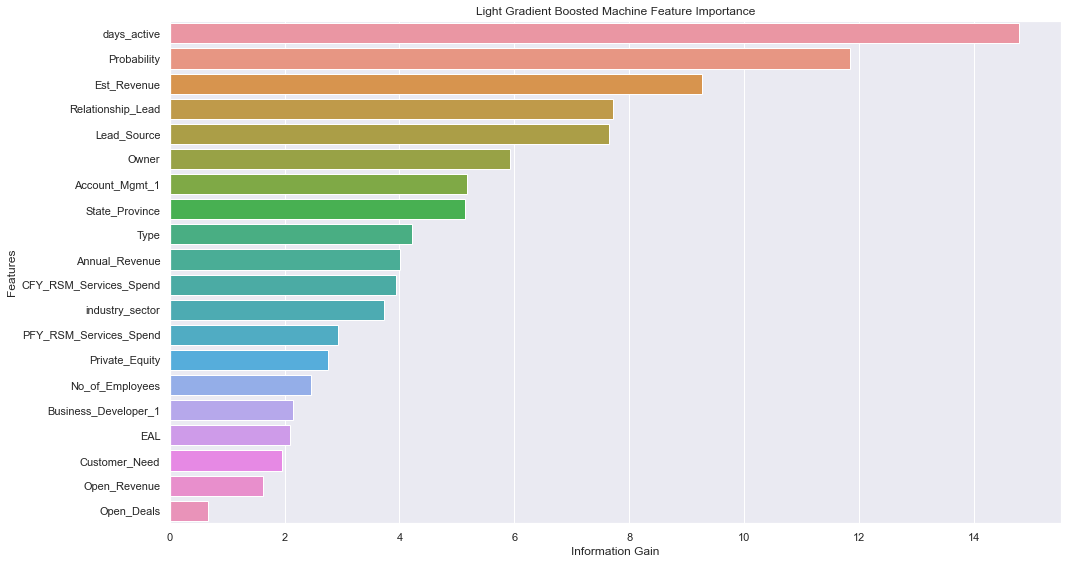

In [83]:
"""plot feature importance"""
plot_importance(x_test.columns, lgbm_model.feature_importances_, "Light Gradient Boosted Machine", "Information Gain")

In [74]:
"""simple XGBoost"""
xgboost_model = XGBClassifier()
xgboost_model.fit(x_train, y_train)
predictions = xgboost_model.predict(x_test)
print_report(y_test, predictions)

              precision    recall  f1-score   support

        Lost       0.81      0.85      0.83       285
         Won       0.84      0.80      0.82       275

    accuracy                           0.82       560
   macro avg       0.83      0.82      0.82       560
weighted avg       0.83      0.82      0.82       560



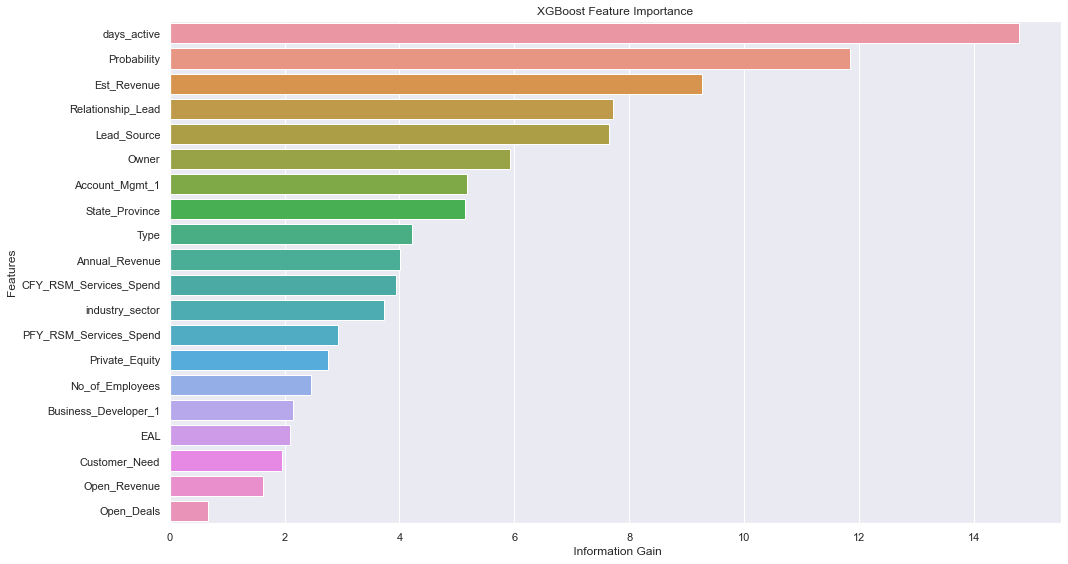

In [81]:
"""plot feature importance"""
plot_importance(x_test.columns, xgboost_model.feature_importances_, "XGBoost", " Information Gain")

In [65]:
"""simple catboost"""
catboost_model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)


In [66]:
catboost_model.fit(
    x_train_cat, y_train_cat,
    cat_features=x_catboost_categorical_idx,
    eval_set=(x_test_cat, y_test_cat),
     #logging_level='Verbose',  # you can uncomment this for text output
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [75]:
predictions = catboost_model.predict(x_test_cat)
print_report(y_test_cat, predictions)

              precision    recall  f1-score   support

        Lost       0.84      0.85      0.84       285
         Won       0.84      0.83      0.84       275

    accuracy                           0.84       560
   macro avg       0.84      0.84      0.84       560
weighted avg       0.84      0.84      0.84       560



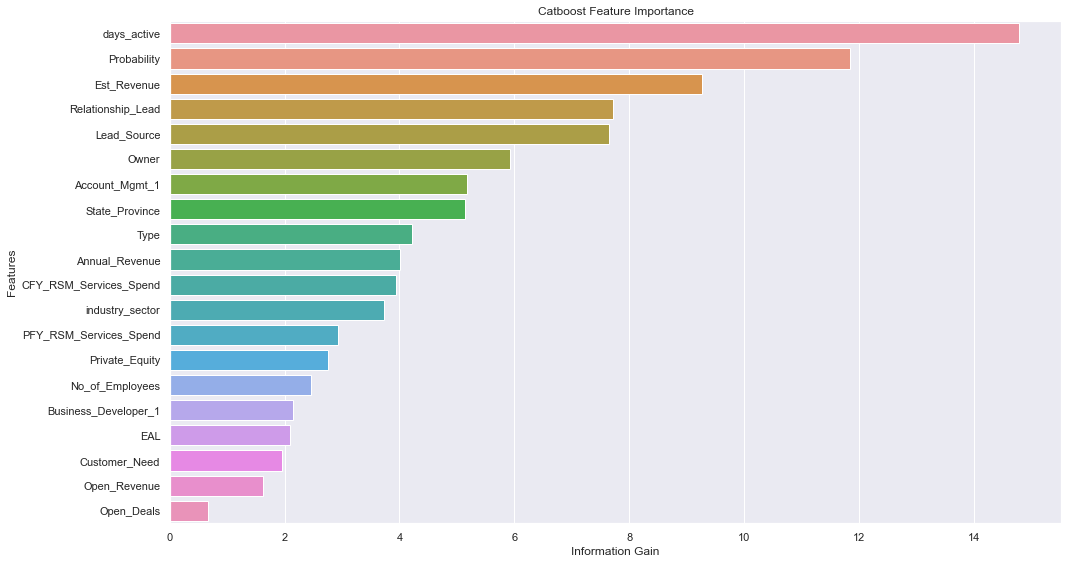

In [82]:
"""plot feature importance"""
plot_importance(x_test_cat.columns, catboost_model.get_feature_importance(), "Catboost", "Information Gain")

NameError: name 'model_type' is not defined

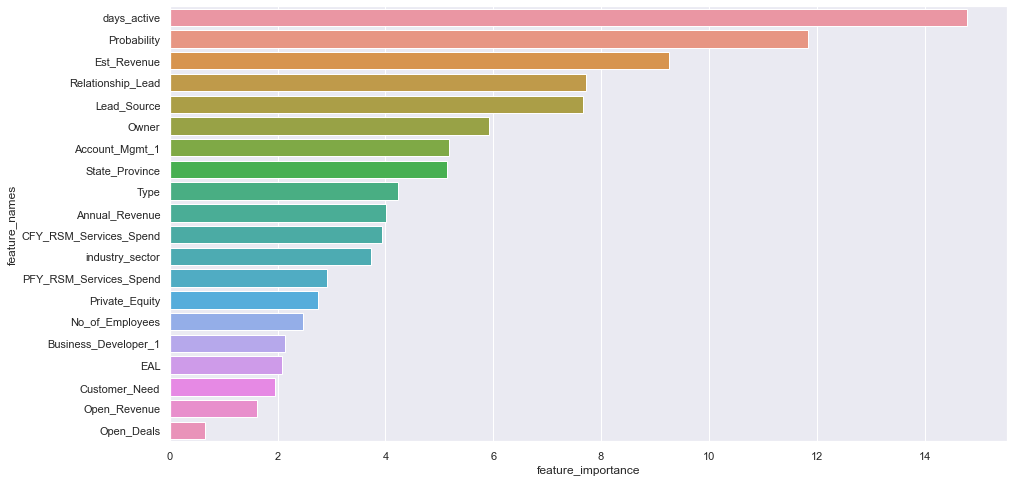

In [69]:
#Create arrays from feature importance and feature names
feature_importance = np.array(catboost_model.get_feature_importance())
feature_names = np.array(x_test_cat.columns)

#Create a DataFrame using a Dictionary
catboost_results = {'feature_names':feature_names,'feature_importance':feature_importance}
catboost_results = pd.DataFrame(catboost_results)

#Sort the DataFrame in order decreasing feature importance
catboost_results.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
plt.figure(figsize=(15,8))
#Plot Searborn bar chart
sns.barplot(x=catboost_results['feature_importance'], y=catboost_results['feature_names'])
#Add chart labels
plt.title(model_type + ' FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')
plt.tight_layout()
plt.show()
